### Import Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import yaml

# ML metrics
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize

# Display settings
sns.set(style="whitegrid")

### Load Config

In [2]:
# Load hyperparameters and thresholds from training.yml
with open("../../configs/training.yml", "r") as f:
    config = yaml.safe_load(f)

risk_threshold = config['thresholds']['risk_flag']

### Load Test data

In [3]:
X_test = pd.read_csv("../../data/processed/X_test.csv")
y_test = pd.read_csv("../../data/processed/y_test.csv")
y_test_array = y_test.values.ravel()  # flatten to 1D array if needed

### Load Best model

In [4]:
best_model = joblib.load("../../models/best_model.pkl")

# Make Prediction

In [5]:
# 1️⃣ Get unique class labels
classes = np.unique(y_test_array)
n_classes = len(classes)

# 2️⃣ Binarize the target (needed for multiclass ROC)
y_test_bin = label_binarize(y_test_array, classes=classes)


# Predict probabilities for the positive class
y_probs = best_model.predict_proba(X_test)[:, 1]

# Apply risk threshold
y_pred = best_model.predict(X_test)

# Save predictions for reporting
prediction = pd.DataFrame({
    'y_true': y_test.squeeze(),
    'y_prob': y_probs,
    'y_pred': y_pred
})
prediction 

,y_true,y_prob,y_pred
0,0,0.279138,0
1,0,0.343254,0
2,1,0.379451,0
3,2,0.244045,2
4,2,0.095984,2
...,...,...,...
438,2,0.088231,2
439,2,0.284877,2
440,1,0.086899,2
441,2,0.241524,2


In [6]:
#save to csv
prediction.to_csv("../../reports/predictions.csv", index=False)

Compute Metrics

In [7]:
# For multiclass ROC AUC, use the full probability matrix

y_probs_full = best_model.predict_proba(X_test)  # Use predict_proba for probabilities

roc_auc = roc_auc_score(y_test_array, y_probs_full, multi_class='ovr')
f1 = f1_score(y_test_array, y_pred, average='weighted')
accuracy = accuracy_score(y_test_array, y_pred)  # Fix: use multiclass labels for accuracy
precision = precision_score(y_test_array, y_pred, average='weighted')
recall = recall_score(y_test_array, y_pred, average='weighted')
cm = confusion_matrix(y_test_array, y_pred)
print(f"ROC AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:")
print(cm)

ROC AUC: 0.8815
F1 Score: 0.7431
Accuracy: 0.7698
Precision: 0.7502
Recall: 0.7698
Confusion Matrix:
[[110   9  23]
 [ 23  20  37]
 [  5   5 211]]


# save the result

In [8]:
result = pd.DataFrame({
    'ROC AUC': [roc_auc],
    "F1 Score": [f1], 
    "Accuracy" : [accuracy],
    "Precision": [precision],
    "Recall" : [recall]
})
print(result)
result.to_csv("../../reports/result.csv", index=False)

    ROC AUC  F1 Score  Accuracy  Precision    Recall
0  0.881487  0.743112  0.769752   0.750152  0.769752


Plot ROC Curve

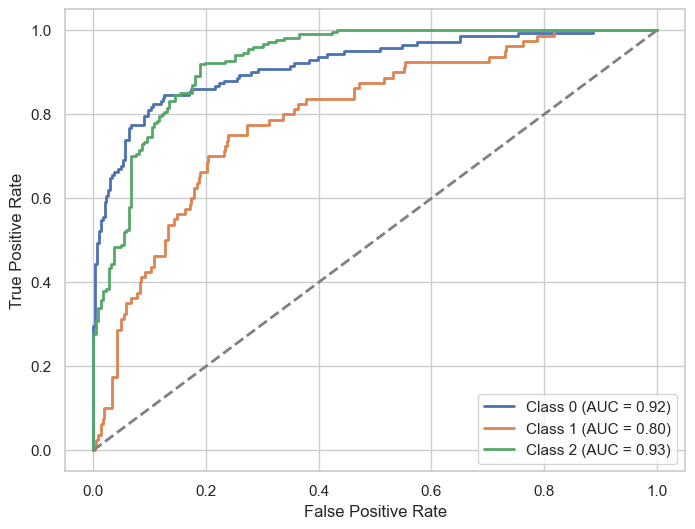

In [9]:
# 3️⃣ Plot ROC for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs_full[:, i]) # type: ignore
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

# 4️⃣ Plot diagonal reference line
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.title = "ROC Curves - Multiclass Classification"
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("../../reports/roc_curve.png")
plt.show()

### Plot Confusion Matrix

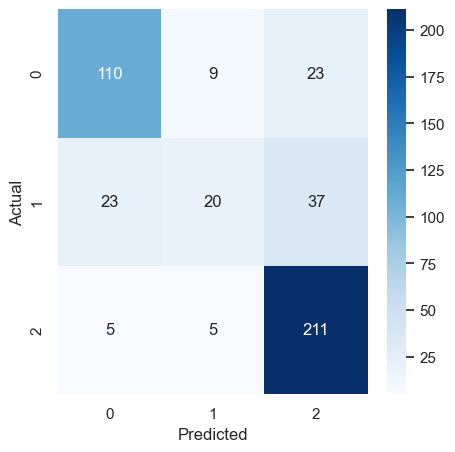

In [10]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title = "Confusion Matrix - Test Set"
plt.savefig("../../reports/confusion_matrix.png")
plt.show()

### Feature Importance

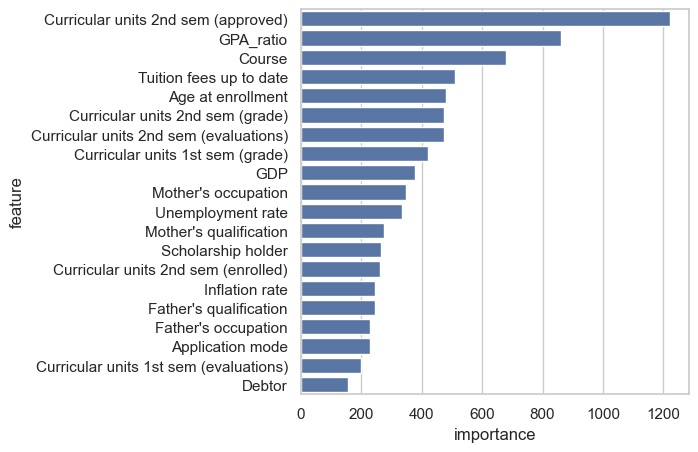

In [11]:
importances = best_model.feature_importances_
features = X_test.columns

feat_imp = pd.DataFrame({"feature": features, "importance": importances})
feat_imp = feat_imp.sort_values(by="importance", ascending=False)
# print(feat_imp)

plt.figure(figsize=(5,5))
sns.barplot(x='importance', y='feature', data=feat_imp.head(20))
plt.title = "Top 20 Important Features"
plt.savefig("../../reports/Important_Features.png", bbox_inches='tight')
plt.show()



### Clasifiction report

In [12]:
# Generate classification report
report = classification_report(y_test, y_pred, digits=3)

# Save as text file
with open("../../reports/classification_report.txt", "w") as f:
    f.write("Classification Report\n")
    f.write("=====================\n\n")
    f.write(report) # type: ignore

print(report)

              precision    recall  f1-score   support

           0      0.797     0.775     0.786       142
           1      0.588     0.250     0.351        80
           2      0.779     0.955     0.858       221

    accuracy                          0.770       443
   macro avg      0.721     0.660     0.665       443
weighted avg      0.750     0.770     0.743       443



In [13]:
from sklearn.metrics import precision_recall_curve, f1_score

# Choose the class for which to optimize the threshold (e.g., class 1)
target_class = 1

# Binarize the true labels for the selected class
y_true_bin = (y_test_array == target_class).astype(int)
y_score = y_probs_full[:, target_class]

# Get precision-recall pairs for different thresholds
precisions, recalls, thresholds = precision_recall_curve(y_true_bin, y_score)

# Compute F1 for each threshold (avoid division by zero)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_threshold = thresholds[f1_scores.argmax()]

print("Best threshold for class", target_class, "based on F1:", best_threshold)

# Predict using this optimal threshold for the selected class
y_pred_optimal = (y_score >= best_threshold).astype(int)

# Recalculate metrics for the selected class
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report (Optimized Threshold for class {}):".format(target_class))
print(classification_report(y_true_bin, y_pred_optimal, digits=3))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true_bin, y_pred_optimal))


Best threshold for class 1 based on F1: 0.22977519478301175
Classification Report (Optimized Threshold for class 1):
              precision    recall  f1-score   support

           0      0.923     0.796     0.855       363
           1      0.431     0.700     0.533        80

    accuracy                          0.779       443
   macro avg      0.677     0.748     0.694       443
weighted avg      0.834     0.779     0.797       443


Confusion Matrix:
[[289  74]
 [ 24  56]]
